In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
from sentence_transformers import SentenceTransformer
import torch

In [9]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zainabshakruwala/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/zainabshakruwala/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/zainabshakruwala/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [10]:
FILE_PATH = 'training.1600000.processed.noemoticon.csv'
COL_NAMES = ['target','ids','date','flag','user','text']
df = pd.read_csv(FILE_PATH, encoding = "ISO-8859-1", names = COL_NAMES)

In [11]:
df['sentiment'] = df['target'].map({0:'Negative', 4:'Positive'})

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   target     1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
 6   sentiment  1600000 non-null  object
dtypes: int64(2), object(5)
memory usage: 85.4+ MB


In [13]:
df.isnull().sum()

target       0
ids          0
date         0
flag         0
user         0
text         0
sentiment    0
dtype: int64

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df = df[['sentiment', 'text']]

In [16]:
df['sentiment'].value_counts()

sentiment
Negative    800000
Positive    800000
Name: count, dtype: int64

In [17]:
df['text'] = df['text'].str.lower()

Removing Repetitions

In [18]:
sequencePattern = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

def removing_consecutive(data):
    return re.sub(sequencePattern, seqReplacePattern, data)

df['text'] = df['text'].apply(removing_consecutive)

In [19]:
url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
def cleaning_URLs(data):
    return re.sub(url_pattern,'',data)
df['text'] =df['text'].apply(cleaning_URLs)

In [20]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
def replacing_emojis(data):
    text = []
    for word in data.split():
        if word not in emojis.keys():
            text.append(word)
        else:
            text.append(emojis[word])
    return ' '.join(text)

df['text'] = df['text'].apply(replacing_emojis)

In [21]:
tag_pattern = '@[^\s]+'

def removing_tag(data):
    return re.sub(tag_pattern, '', data)

df['text'] =df['text'].apply(removing_tag)

In [22]:
import string
english_punctuations = string.punctuation
def cleaning_punc(data):
    translator = str.maketrans('','',english_punctuations )
    return data.translate(translator)

df['text'] = df['text'].apply(cleaning_punc)

In [23]:
from nltk.corpus import stopwords
stop_words=  set(stopwords.words('english'))
stop_words.update(["go", "im"])

def removing_stopword(data):
    text = []
    for word in data.split():
        if word not in stop_words:
            text.append(word)
    return ' '.join(text)

df['text'] = df['text'].apply(removing_stopword)
df['text'].tail()


1599995                      woke school best feeling ever
1599996        thewdbcom cool hear old walt interviews â«
1599997                    ready mojo makeover ask details
1599998    happy 38th birthday boo time tupac amaru shakur
1599999                               happy charitytuesday
Name: text, dtype: object

In [24]:
def removing_single(data):
    text = [ word for word in data.split() if len(word)>1]
    return ' '.join(text)
df['text'] = df['text'].apply(removing_single)

In [25]:

lm = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet POS tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ  
    elif treebank_tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif treebank_tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun if unknown

def lemmatization(data):
    words = data.split()  # Split text into words
    pos_tags = pos_tag(words)  # Tag each word with its part of speech
    lemmitized_words = [lm.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]  # Lemmatize using POS tag
    return ' '.join(lemmitized_words)  # Join lemmatized words back into a string

# Apply lemmatization to each text entry in the DataFrame
df['text'] = df['text'].apply(lemmatization)


# Negative Sentiments

Text(0.5, 1.0, 'Negative Words')

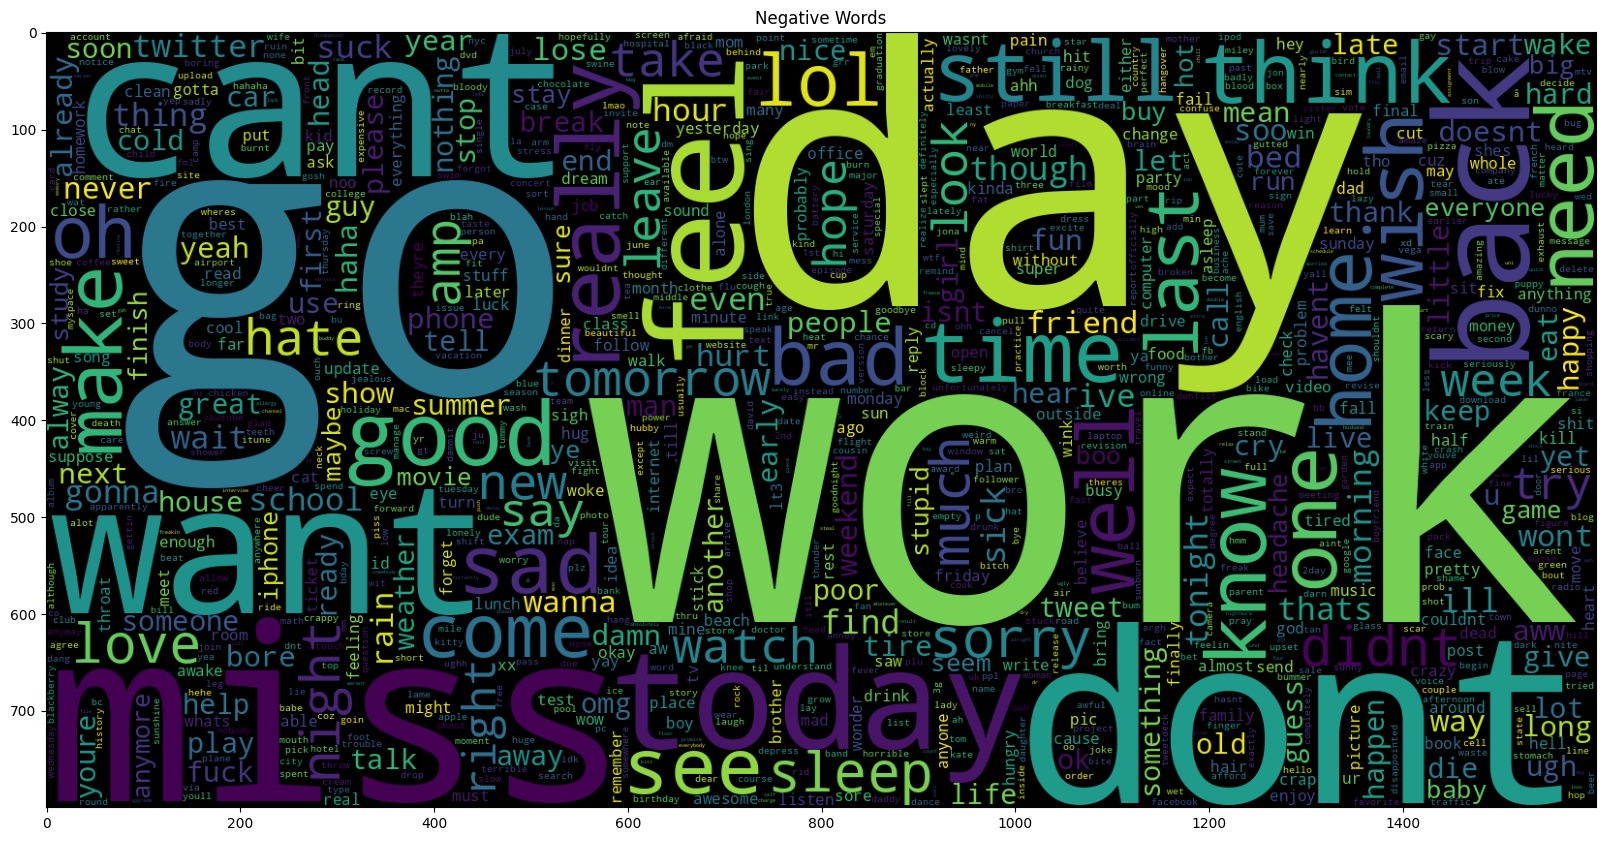

In [26]:
data_neg = df[df['sentiment']=='Negative'].text
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)
plt.title ("Negative Words")

## Topic Modelling of Negative Data

In [27]:
neg = df[df['sentiment']=='Negative']
neg['tweet_len']= neg['text'].apply(lambda x : len(x.split()))

/var/folders/lr/r2t5zqq959sd0hhfx1kbj5_r0000gn/T/ipykernel_34380/3439245569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg['tweet_len']= neg['text'].apply(lambda x : len(x.split()))


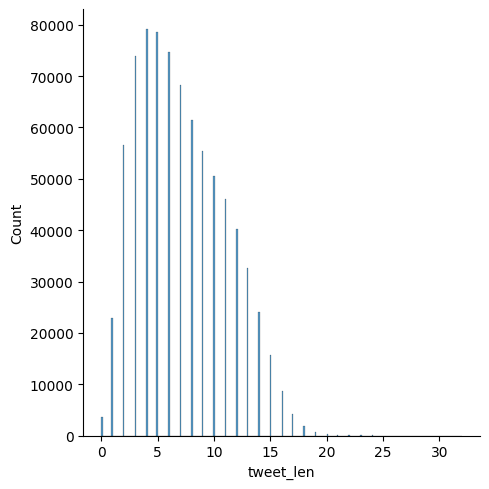

In [28]:
sns.displot(neg.tweet_len)

In [30]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

mps


In [31]:
from bertopic import BERTopic
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2", device = device)
model = BERTopic(embedding_model=embedding_model,verbose = True,  min_topic_size=10)
topics, _= model.fit_transform(neg.text)

2024-09-12 15:07:03,808 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 25000/25000 [11:11<00:00, 37.23it/s]
2024-09-12 15:18:21,586 - BERTopic - Embedding - Completed ✓
2024-09-12 15:18:21,587 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-09-12 15:46:52,744 - BERTopic - Dimensionality - Completed ✓
2024-09-12 15:46:52,757 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling pa

In [32]:
freq = model.get_topic_info()
print("Number of topics: {}".format(len(freq)))
freq.head()

Number of topics: 5823


,Topic,Count,Name,Representation,Representative_Docs
0,-1,354201,-1_bed_sleep_night_school,"[bed, sleep, night, school, baby, guy, talk, d...",[everyone coz friday doesnt mean live life out...
1,0,3696,0_airport_france_flight_plane,"[airport, france, flight, plane, air, 447, pas...","[news air france flight, air france miss fligh..."
2,1,3659,1_finkin_dyke_ut_sentence,"[finkin, dyke, ut, sentence, special, , , , , ]","[, sentence, finkin]"
3,2,2750,2_tweet_tweeter_retweet_tweeting,"[tweet, tweeter, retweet, tweeting, tweeps, tw...","[one tweet, tweet back, tweet day]"
4,3,2640,3_headache_massive_major_headachee,"[headache, massive, major, headachee, killer, ...","[work headache, headache work, headache work]"


In [33]:
model.visualize_barchart(top_n_topics = 7)

# Positive Sentiment

In [34]:
pos = df[df['sentiment']=='Positive']
pos['tweet_len']= pos['text'].apply(lambda x : len(x.split()))

In [37]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
topics, _= model.fit_transform(pos.text)

2024-09-12 16:44:49,136 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 25000/25000 [11:22<00:00, 36.60it/s]
2024-09-12 16:56:17,312 - BERTopic - Embedding - Completed ✓
2024-09-12 16:56:17,313 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-12 17:25:32,625 - BERTopic - Dimensionality - Completed ✓
2024-09-12 17:25:32,663 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-12 17:27:26,478 - BERTopic - Cluster - Completed ✓
2024-09-12 17:27:26,626 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-12 17:27:33,561 - BERTopic - Representation - Completed ✓


## Topic Modelling of Positive Tweets

In [38]:
model.visualize_barchart(top_n_topics = 7)

Text(0.5, 1.0, 'Positive Words')

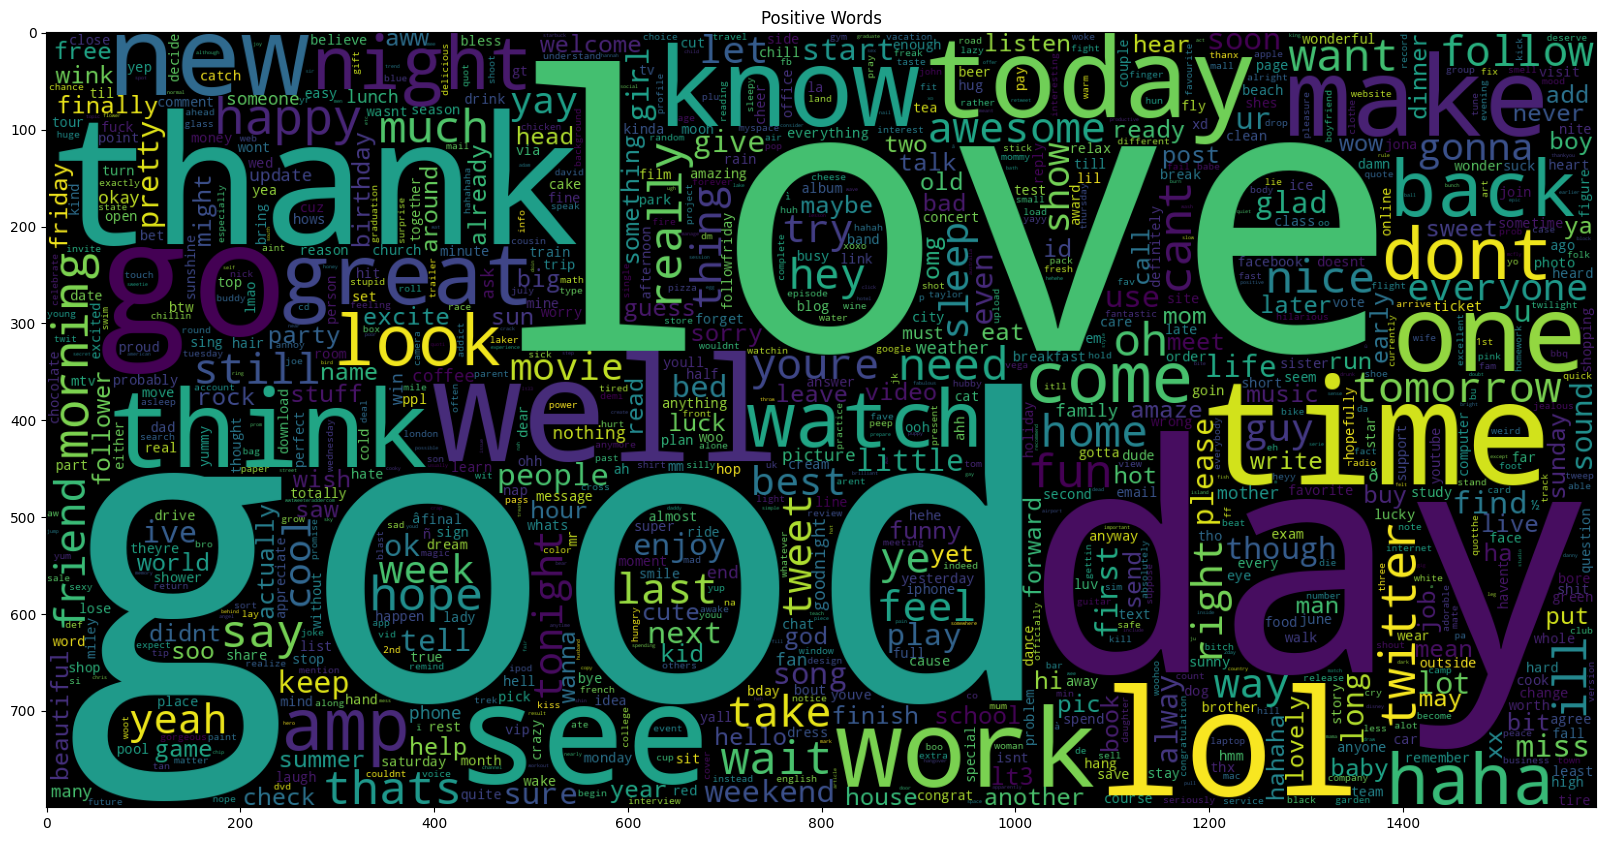

In [35]:
data_pos = df[df['sentiment']=='Positive'].text
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, width= 1600, height=800, collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)
plt.title("Positive Words")

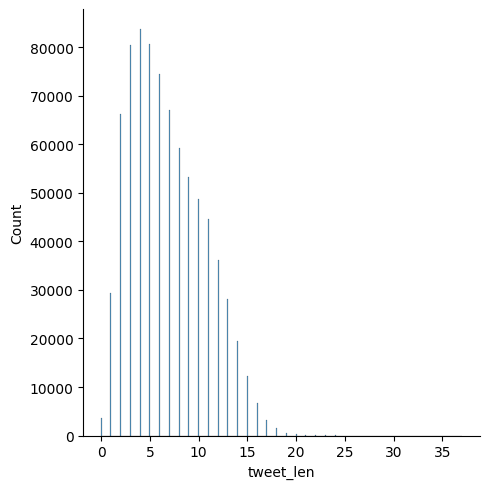

In [36]:
sns.displot(pos.tweet_len)